# Intuit QuickBook

### INTRODUCTION

QuickBooks is an accounting software package developed and marketed by Intuit. The key event took place in 1995 with release of Version 3 of QuickBooks. QuickBooks products are geared mainly toward small and medium-sized businesses and offer on-premises accounting applications. Although, the products at that time could only be purchased through Intuit Direct (i.e., delivery by mail) or through “brick-and-mortar” retailers like Best Buy.
Through this exercise, we do a detailed analysis of modeling the response to an upselling campaign by using testing and predictive analysis to target the "right" customers. 

In [1]:
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as sms
#import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier


In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = rsm.ifelse(intuit75k.res1 == "Yes", 1, 0)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [3]:
# show dataset description
rsm.describe(intuit75k)

## Intuit: Quickbooks upgrade

The purpose of this exercise is to gain experience modeling the response to an upsell campaign. The `intuit75k.rds` file contains data on 75,000 (small) businesses that were selected randomly from the 801,821 that were sent the wave-1 mailing. The mailing contained an offer to upgrade to the latest version of the Quickbooks software. 

Variable `res1` denotes which of these businesses responded to the mailing by purchasing Quickbooks version 3.0 from Intuit Direct. Note that Intuit Direct sells products directly to its customers rather than through a retailer. Use the available data to predict which businesses that did not respond to the wave-1 mailing, are most likely to respond to the wave-2 mailing. Note that variables were added, deleted, and recoded so please ignore the variable descriptions in Exhibit 3 in the case in the course reader. Instead, use the variable descriptions below:

## Variable description

* id: Small business customer ID
* zip: 5-Digit ZIP Code (00000=unknown, 99999=international ZIPs).
* zip_bins: Zip-code bins (20 approx. equal sized bins from lowest to highest zip code number)
* sex: "Female", "Male", or "Unknown"
* bizflag: Business Flag.  Address contains a Business name (1 = yes, 0 = no or unknown).
* numords: Number of orders from Intuit Direct in the previous 36 months
* dollars: Total $ ordered from Intuit Direct in the previous 36 months
* last: Time (in months) since last order from Intuit Direct in previous 36 months
* sincepurch: Time (in months) since original (not upgrade) purchase of Quickbooks
* version1: Is 1 if customer's current Quickbooks is version 1, 0 if version 2
* owntaxprod: Is 1 if customer purchased tax software, 0 otherwise
* upgraded: Is 1 if customer upgraded from Quickbooks vs. 1 to vs. 2
* res1: Response to wave 1 mailing ("Yes" if responded else "No")
* training: 70/30 split, 1 for training sample, 0 for validation sample


In [4]:
intuit75k_training = intuit75k[intuit75k['training'] == 1]
intuit75k_training.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
5,6,12309,3,Male,0,1,20.0,17,17,0,0,1,No,1,0
7,8,55122,11,Male,1,1,24.5,4,17,1,0,0,No,1,0
9,10,20036,5,Male,0,3,73.5,10,9,0,0,0,No,1,0


In [5]:
intuit75k_training["res1_yes"].value_counts()

0    50002
1     2498
Name: res1_yes, dtype: int64

#### Percentage of customers responded (i.e., bought anything)

In [6]:
## Percentage of people who bought the version 3
perc_yes_train = str(round((intuit75k_training["res1_yes"].value_counts()[1]/len(intuit75k_training))*100,2)) + '%'
perc_yes_train

'4.76%'

#### Create independent quintile variables for recency, frequency and monetary

In [7]:
intuit75k = intuit75k.assign(rec_iq = rsm.xtile(intuit75k['last'], 5))
intuit75k = intuit75k.assign(freq_iq = rsm.xtile(intuit75k['numords'], 5, rev = True))
intuit75k = intuit75k.assign(mon_iq = rsm.xtile(intuit75k['dollars'], 5, rev = True))

RFM is a widely used technique for doing analysis that uses data based on existing customer behaviour to predict how a new customer is likely to act in the future. This is built using three key factors - Recency - Frequency - Monetary (RFM), selecting significant customers and dividing them into different groups based on similarities found on this variables and past behavioral data. 

- Recency(R) is the number of days since the customer's last purchase. 
- Frequency(F) is the number of times the customer has made a purchase. 
- Monetary (M) is the total amount spent by the customer in the same period. 

RFM analysis enables marketers to increase revenue by targeting specific groups of existing customers (customer segmentation) by doing comparison between found segregation on the factors described above. It gives a sense of how much revenue comes from repeat customers (versus new customers). Each variable aims to segregate in 5 different bins

- Recency: Bin 1 depicts the customers that were most recent and bin 5 depicts the least recent.
- Frequency: Bin 1 depicts the customers that were more frequently made purchases and bin 5 depicts the least frequent.
- Monetary: Bin 1 depicts the customers that have spent the most amount and bin 5 depicts the ones that spent the least.

#### Create bar charts showing the response rate (i.e., the proportion of customers who bought something) for this deal per (independent) recency, frequency, and monetary quintile 

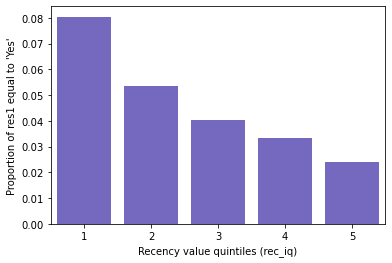

In [8]:
fig1 = rsm.prop_plot(intuit75k[intuit75k['training']==1], "rec_iq", "res1", "Yes")
fig1 = fig1.set_xlabel("Recency value quintiles (rec_iq)")

Recency Chart : The above graph depicts the proportion of customers who responded "yes" to waive 1 mail that was send out, per independent recency. The customers in bin 1 had the highest response rate from the mail sent out as opposed to ones in bin 5. It shows that the response rate from the top quintile (20% group) was 9.00%, while the next quintile responded at a rate of ~5.4%. The last quintile had a response rate of ~2.3%. 

This graph shows that the recency factor has a constant downgrade at every level on the probability of purchasing the latest upgrade offer thru email. Although we can appreciate the biggest drop from bin1 to bin2, which would elevate the predictive probabilities to the group that pertains in bin1 the most.

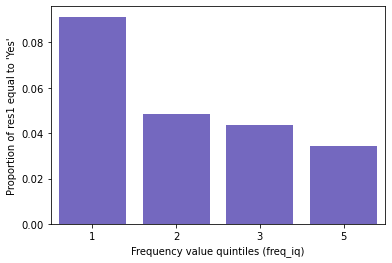

In [9]:
fig2 = rsm.prop_plot(intuit75k[intuit75k['training']==1], "freq_iq", "res1", "Yes")
fig2 = fig2.set_xlabel("Frequency value quintiles (freq_iq)")

Frequency Chart : The above graph depicts the proportion of customers who responded "yes" to waive 1 mail that was send out, per independent frequency. The customers in bin 1 had the highest frequency rate from the mail sent out as opposed to ones in bin 5. The customers in bin 1 had the highest response rate from the mail sent out as opposed to ones in bin 5. It shows that the response rate from the top quintile (20% group) was 8.00%, while the next quintile responded at a rate of 5.00%. The last quintile had a response rate of ~3.3%. 

This graph shows that the frequency factor has a drop of almost half from bin1 to bin2 on the probability of purchasing the latest upgrade offer thru email. Although it keeps downgrading from bin2 through bin5, not much drop is seen, meaning that in this case segmentation on bin1 will have a clearer advantage difference compare to the rest.

Additionally we see that bin4 is skipped in this case, that is due to the fact that the amount of IDs found among bin3 and beyond were not enough to be scalable with the first two bins.

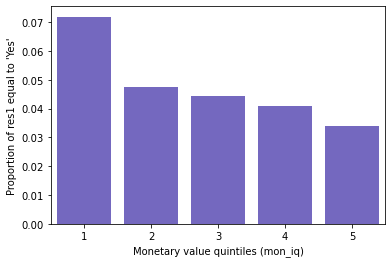

In [10]:
fig3 = rsm.prop_plot(intuit75k[intuit75k['training']==1], "mon_iq", "res1", "Yes")
fig3 = fig3.set_xlabel("Monetary value quintiles (mon_iq)")

Monetory Chart : The above graph depicts the proportion of customers who responded "yes" to waive 1 mail that was send out, per independent monetory. The customers in bin 1 had the highest expenditure rate from the mail sent out as opposed to ones in bin 5. It shows that the response rate from the top quintile (20% group) was 7.00%, while the next quintile responded at a rate of 4.5%. The last quintile had a response rate of 3.2%. 

This graph shows that the monetary factor has again the most significant drop between bin1 and bin2. Then from bin2 through bin5 we appreciate a consant downgrade but with not much difference between them. Therefore segregation on bin1 will have the most probability of purchasing the latest upgrade thru email and with not much difference on the rest of the segmentations.

#### Generate Independent RFM index 

To perform RFM analysis, we bin the customers using Independent or Sequential Method. 
In independent method, the ranks of RFM are assigned independently. The interpretation of each rank becomes unambiguous. The monetory value of a bin 4 in 234 is interpreted the same way as that in 114. This is one advantage of interpretting the bin values in independent approach. One disadvantage of this approach is that incase of less samples, it can result in a less even distribution of the combined RFM scores i.e the quantities of customers in the RFM cells might be quite different.

In [11]:
intuit75k = intuit75k.assign(
    rfm_iq=intuit75k.rec_iq.astype(str)
    + intuit75k.freq_iq.astype(str)
    + intuit75k.mon_iq.astype(str)
)

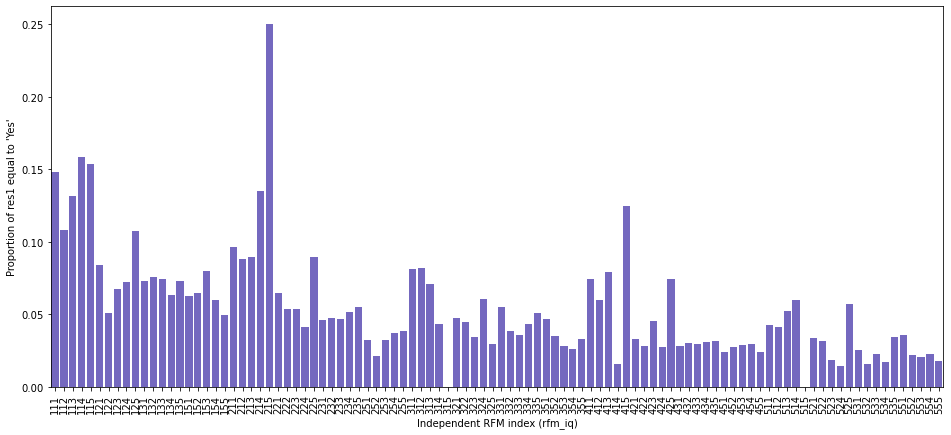

In [12]:
plt.figure(figsize=(16, 7))
# fig = rsm.prop_plot(bbb, "rfm_iq", "buyer", "yes", breakeven=breakeven)
fig = rsm.prop_plot(intuit75k, "rfm_iq", "res1", "Yes")
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig = fig.set(xlabel="Independent RFM index (rfm_iq)")

RFM analysis depends on recency, frequency and monetary measures, but the real power of this technique comes from combining them into a three digit RFM "cell code". Hence, we now put all the customers in bins of 3 digits (555, 554, 553, 552, 551, 545,...down to 111). There are 125 different "cells" in all. 

We can observe that there are few bins with no customers in them like bin number 315 and 515. This is due to the nature of the customers in such bins. A customer in 515 is bound to be the least recent but more frequent and frugal in expenditure. Such a customer is generally very hard to find.

In [13]:
# state your assumptions relevant to calculate the breakeven response rate
# breakeven should be of type `float`

cost = 1.41 # each mail piece costs $1.41
margin = 60  # the margin (or net revenue) from each responder, excluding the mailing cost, is $60
breakeven =  cost/margin # float, length 1

breakeven

0.0235

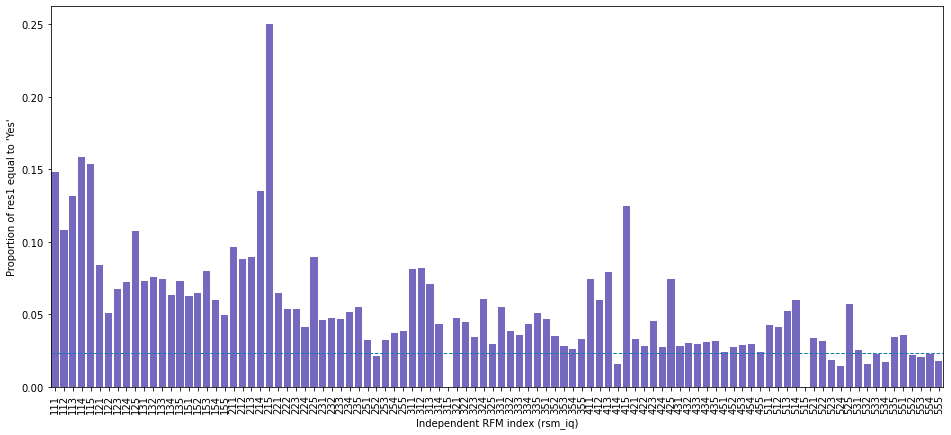

In [14]:
plt.figure(figsize=(16, 7))
fig_rfm_iq = rsm.prop_plot(intuit75k, "rfm_iq", "res1", "Yes", breakeven = breakeven)
fig_rfm_iq.set_xticklabels(fig_rfm_iq.get_xticklabels(), rotation=90)
fig_rfm_iq = fig_rfm_iq.set(xlabel="Independent RFM index (rsm_iq)")

Now, we calculate a breakeven point to further modify the customers we will be targetting. We will only send mails to those who's response rate lies above the breakeven point. Break even means that the net revenue (profit) from sales to members of the cell exactly paid for the cost of mailing to the cell members.

Given, 
each mail piece costs 1.41 usd
the margin (or net revenue) from each responder, excluding the mailing cost, is 60 usd
So, breakeven =  cost/margin

The graph above shows that we should be targetting only the customers in independent bins who lie above our breakeven point of 0.023 for the company to remain in profit.

#### Generate sequential quintiles

To further modify the RFM analysis, we use sequential method to assign the ranks of RFM in order. In this method, first the Recency values are assigned. Then within each recency rank, customers are assigned a frequency rank, and within each frequency rank, customer are then assigned a monetary rank. This tends to take into account all the three factors in each bin value and hence provide a better even distribution of combined RFM scores. Hence the advantage of this method is that the numbe of customers in each RFM cell is approximately the same for all cells. The disadvantage is that the meaning of Frequecy and Monetory where the bins are same holds different meaning i.e. a customer with 234 and another with 534 will depict quite a different behaviour from eachother. Their frequency and monetory value might be different even though they have the same scores for them. 

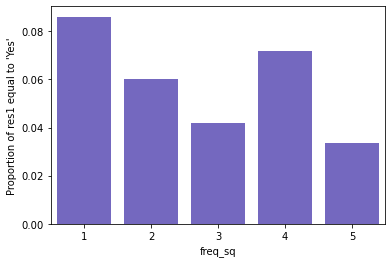

In [15]:
intuit75k = intuit75k.assign(
    freq_sq=intuit75k.groupby("rec_iq").numords.transform(rsm.xtile, 5, rev=True)
)
fig_8 = rsm.prop_plot(intuit75k, "freq_sq", "res1", "Yes")

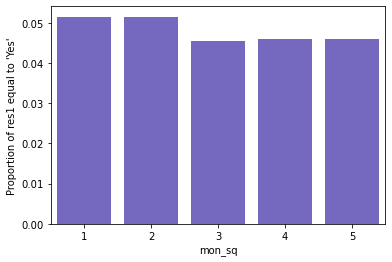

In [16]:
intuit75k = intuit75k.assign(
    mon_sq=intuit75k.groupby(["rec_iq", "freq_sq"]).dollars.transform(rsm.xtile, 5, rev=True)
)
fig_9 = rsm.prop_plot(intuit75k, "mon_sq", "res1", "Yes")

Sequential model creates nested binning, a simple rank is assigned to recency values, which in this case t=is the same recency binning that we did in Independent RFM. However, in sequential, within each recency rank, customers are then assigned a frequency rank  and within each frequency rank, customers are assigned a monetary rank as depiceted above.

In [17]:
intuit75k = intuit75k.assign(
    rfm_sq=intuit75k.rec_iq.astype(str)
    + intuit75k.freq_sq.astype(str)
    + intuit75k.mon_sq.astype(str)
)

intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,res1,training,res1_yes,rec_iq,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq
0,1,94553,18,Male,0,2,109.5,5,12,0,...,No,1,0,1,3,2,132,4,2,142
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,No,0,0,1,5,3,153,5,2,152
2,3,37091,8,Male,0,4,93.0,14,29,0,...,No,0,0,3,1,2,312,1,5,315
3,4,02125,1,Male,0,1,22.0,17,1,0,...,No,1,0,3,5,5,355,5,4,354
4,5,60201,11,Male,0,1,24.5,2,3,0,...,No,0,0,1,5,5,155,5,4,154


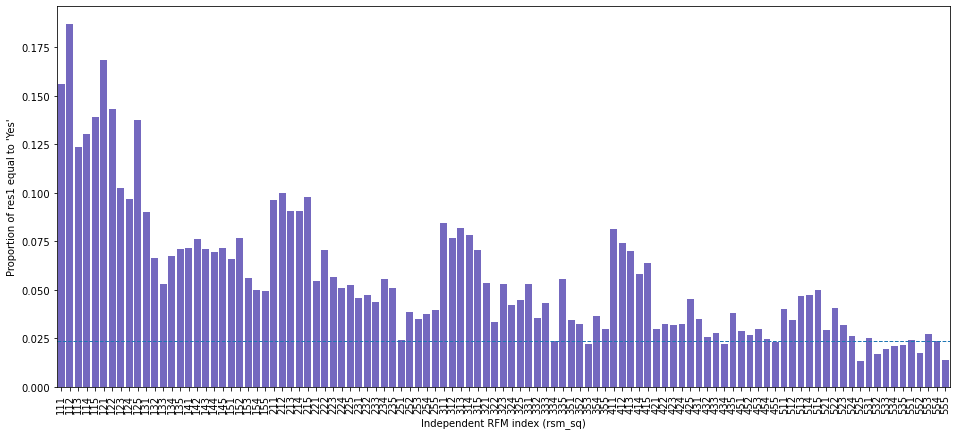

In [18]:
plt.figure(figsize=(16, 7))
# fig = rsm.prop_plot(bbb, "rfm_iq", "buyer", "yes", breakeven=breakeven)
fig_rfm_sq = rsm.prop_plot(intuit75k, "rfm_sq", "res1", "Yes", breakeven = breakeven)
fig_rfm_sq.set_xticklabels(fig_rfm_sq.get_xticklabels(), rotation=90)
fig_rfm_sq = fig_rfm_sq.set(xlabel="Independent RFM index (rsm_sq)")

The graph above shows that we should be targetting only the customers in sequencial bins who lie above our breakeven point of 0.023 for the company to remain in profit after sequential bining. We also observe that there are no empty bins in sequencial RFM indexing as opposed to independent one. 

#### Calculation of performance without targetting // TEST DATA

In [19]:
intuit75k_testdf = intuit75k[intuit75k['training'] == 0]

In [20]:
intuit75k_testdf["res1_yes"].agg(["count", "mean"])

count    22500.000000
mean         0.049022
Name: res1_yes, dtype: float64

In [21]:
intuit75k_testdf.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,res1,training,res1_yes,rec_iq,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,No,0,0,1,5,3,153,5,2,152
2,3,37091,8,Male,0,4,93.0,14,29,0,...,No,0,0,3,1,2,312,1,5,315
4,5,60201,11,Male,0,1,24.5,2,3,0,...,No,0,0,1,5,5,155,5,4,154
6,7,22980,5,Male,0,1,49.5,13,36,1,...,No,0,0,2,5,4,254,5,2,252
8,9,34950,8,Male,0,1,44.5,15,4,0,...,No,0,0,3,5,4,354,5,3,353


In [22]:
intuit75k_testdf['res1_yes'].value_counts(normalize = True)[1]

0.049022222222222224

In [23]:
perc_emails = 1
nr_emails_nt = len(intuit75k_testdf) # total number of emails that would be sent out
email_cost_nt = cost*nr_emails_nt  # cost of sending an email (float)
response_rate_nt = intuit75k_testdf['res1_yes'].value_counts(normalize = True)[1]
nr_responses_nt = response_rate_nt * nr_emails_nt # total number of positive responses
revenue_nt = margin*nr_responses_nt# total revenue 
profit_nt = margin * nr_responses_nt - email_cost_nt# total profit 
ROME_nt = profit_nt/email_cost_nt# Return on Marketing Expenditures expressed as a proportion (no rounding)

profit_nt, ROME_nt

(34455.0, 1.0860520094562647)

In [24]:
response_rate_nt

0.049022222222222224

In [25]:
print(
    f"""Quickbooks would sms all {int(nr_emails_nt):,} ({round((100 * perc_emails), 2)}%) customers. The response rate for the selected customers is predicted to be {round((100 * response_rate_nt), 2)}% or {int(nr_responses_nt):,} buyers. The revenue is equal to ${int(revenue_nt):,}. The expected profit is ${int(profit_nt):,}. The email cost is estimated to be ${int(email_cost_nt):,} with a ROME of {round((100 * ROME_nt), 2)}%"""
)

Quickbooks would sms all 22,500 (100%) customers. The response rate for the selected customers is predicted to be 4.9% or 1,103 buyers. The revenue is equal to $66,180. The expected profit is $34,455. The email cost is estimated to be $31,725 with a ROME of 108.61%


#### Evaluate the performance implications of offering the deal to only those customers in RFM cells with a response rate greater than the breakeven response rate// TEST DATA

#### IQ CELLS

In [26]:
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,res1,training,res1_yes,rec_iq,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq
0,1,94553,18,Male,0,2,109.5,5,12,0,...,No,1,0,1,3,2,132,4,2,142
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,No,0,0,1,5,3,153,5,2,152
2,3,37091,8,Male,0,4,93.0,14,29,0,...,No,0,0,3,1,2,312,1,5,315
3,4,02125,1,Male,0,1,22.0,17,1,0,...,No,1,0,3,5,5,355,5,4,354
4,5,60201,11,Male,0,1,24.5,2,3,0,...,No,0,0,1,5,5,155,5,4,154


In [57]:
def response_rate(x, lev="Yes"):
    return np.nanmean(x == lev)

def emailto(x, lev="Yes", breakeven=0):
    return np.nanmean(x == "Yes") > breakeven

In [72]:
intuit75k_testdf_2 = intuit75k[intuit75k['training'] == 0]

In [80]:
intuit75k_testdf_2 = intuit75k_testdf_2.assign(
    rfm_iq_resp=(intuit75k_testdf_2.groupby("rfm_iq").res1.transform(response_rate)),
    emailto_iq=intuit75k_testdf_2.groupby("rfm_iq").res1.transform(emailto, breakeven=breakeven*2)
)

In [81]:
intuit75k_testdf_2.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,res1_yes,rec_iq,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq,rfm_iq_resp,emailto_iq
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,0,1,5,3,153,5,2,152,0.051370,True
2,3,37091,8,Male,0,4,93.0,14,29,0,...,0,3,1,2,312,1,5,315,0.067568,True
4,5,60201,11,Male,0,1,24.5,2,3,0,...,0,1,5,5,155,5,4,154,0.049226,True
6,7,22980,5,Male,0,1,49.5,13,36,1,...,0,2,5,4,254,5,2,252,0.028623,False
8,9,34950,8,Male,0,1,44.5,15,4,0,...,0,3,5,4,354,5,3,353,0.026408,False


In [82]:
intuit75k_testdf_2.emailto_iq.value_counts()

False    13323
True      9177
Name: emailto_iq, dtype: int64

In [83]:
intuit75k_testdf_2a = intuit75k_testdf_2[intuit75k_testdf_2['emailto_iq'] == True]
intuit75k_testdf_2a.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,res1_yes,rec_iq,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq,rfm_iq_resp,emailto_iq
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,0,1,5,3,153,5,2,152,0.051370,True
2,3,37091,8,Male,0,4,93.0,14,29,0,...,0,3,1,2,312,1,5,315,0.067568,True
4,5,60201,11,Male,0,1,24.5,2,3,0,...,0,1,5,5,155,5,4,154,0.049226,True
11,12,91942,17,Male,1,5,79.0,5,21,0,...,1,1,1,3,113,1,5,115,0.180451,True
12,13,27262,6,Male,0,1,38.0,5,22,1,...,0,1,5,4,154,5,3,153,0.057208,True


In [84]:

perc_emails_iq = len(intuit75k_testdf_2a)/len(intuit75k_testdf_2)
nr_emails_iq = len(intuit75k_testdf_2a) # total number of emails that would be sent out
email_cost_iq = cost*nr_emails_iq # cost of sending an email (float)
response_rate_iq = intuit75k_testdf_2a['res1_yes'].value_counts(normalize = True)[1]
nr_responses_iq = response_rate_iq * nr_emails_iq # total number of positive responses
revenue_iq = margin*nr_responses_iq# total revenue 
profit_iq = margin * nr_responses_iq - email_cost_iq# total profit 
ROME_iq = profit_iq/email_cost_iq# Return on Marketing Expenditures expressed as a proportion (no rounding)

profit_iq, ROME_iq

(30380.43, 2.3478701378793887)

In [85]:
print(
    f"""Quickbooks would sms all {int(nr_emails_iq):,} ({round((100 * perc_emails_iq), 2)}%) customers. The response rate for the selected customers is predicted to be {round((100 * response_rate_iq), 2)}% or {int(nr_responses_iq):,} buyers. The revenue is equal to ${int(revenue_iq):,}. The expected profit is ${int(profit_iq):,}. The emai; cost is estimated to be ${int(email_cost_iq):,} with a ROME of {round((100 * ROME_iq), 2)}%"""
)

Quickbooks would sms all 9,177 (40.79%) customers. The response rate for the selected customers is predicted to be 7.87% or 722 buyers. The revenue is equal to $43,320. The expected profit is $30,380. The emai; cost is estimated to be $12,939 with a ROME of 234.79%


In [87]:
#wave 2- scaled
scale1_iq = round((100 * perc_emails_iq), 2)
scale2_iq = round((100 * response_rate_iq), 2) 
tot_emails = 801821 - 38487
total_cost_iq = scale1_iq*tot_emails*cost
total_revenue2 = tot_emails*scale2_iq*margin
profit2 = total_revenue2 - total_cost_iq
profit2

316543999.4574

#### SQ CELLS

In [91]:
intuit75k_testdf_2 = intuit75k_testdf_2.assign(
    rfm_sq_resp=(intuit75k_testdf_2.groupby("rfm_sq").res1.transform(response_rate)),
    emailto_sq=intuit75k_testdf_2.groupby("rfm_sq").res1.transform(emailto, breakeven=breakeven * 2)
)

In [92]:
intuit75k_testdf_2.emailto_sq.value_counts()

False    12921
True      9579
Name: emailto_sq, dtype: int64

In [93]:
intuit75k_testdf_2b = intuit75k_testdf_2[intuit75k_testdf_2['emailto_sq'] == True]
intuit75k_testdf_2b.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq,rfm_iq_resp,emailto_iq,rfm_sq_resp,emailto_sq
2,3,37091,8,Male,0,4,93.0,14,29,0,...,1,2,312,1,5,315,0.067568,True,0.069307,True
4,5,60201,11,Male,0,1,24.5,2,3,0,...,5,5,155,5,4,154,0.049226,True,0.050532,True
11,12,91942,17,Male,1,5,79.0,5,21,0,...,1,3,113,1,5,115,0.180451,True,0.144231,True
12,13,27262,6,Male,0,1,38.0,5,22,1,...,5,4,154,5,3,153,0.057208,True,0.061644,True
14,15,93535,18,Male,0,2,40.5,10,6,0,...,3,4,234,3,5,235,0.036765,False,0.054622,True


In [94]:

perc_emails_sq = len(intuit75k_testdf_2b)/len(intuit75k_testdf_2)
nr_emails_sq = len(intuit75k_testdf_2b)# total number of emails that would be sent out
email_cost_sq = cost*nr_emails_sq # cost of sending an email (float)
response_rate_sq = intuit75k_testdf_2b['res1_yes'].value_counts(normalize = True)[1]
nr_responses_sq = response_rate_sq * nr_emails_sq # total number of positive responses
revenue_sq = margin*nr_responses_sq# total revenue 
profit_sq = margin * nr_responses_sq - email_cost_sq# total profit 
ROME_sq = profit_sq/email_cost_sq# Return on Marketing Expenditures expressed as a proportion (no rounding)

profit_sq, ROME_sq

(31373.61, 2.322871618545)

In [95]:
print(
    f"""Quickbooks would sms all {int(nr_emails_sq):,} ({round((100 * perc_emails_sq), 2)}%) customers. The response rate for the selected customers is predicted to be {round((100 * response_rate_sq), 2)}% or {int(nr_responses_sq):,}
buyers. The revenue is equal to ${int(revenue_sq):,}. The expected profit is ${int(profit_sq):,}. The emai; cost is estimated to be ${int(email_cost_sq):,} with a ROME of {round((100 * ROME_sq), 2)}%"""
)

Quickbooks would sms all 9,579 (42.57%) customers. The response rate for the selected customers is predicted to be 7.81% or 748
buyers. The revenue is equal to $44,880. The expected profit is $31,373. The emai; cost is estimated to be $13,506 with a ROME of 232.29%


In [96]:
#wave2
scale1_sq = round((100 * perc_emails_sq), 2)
scale2_sq = round((100 * response_rate_sq), 2) 
tot_emails = 801821 - 38487
total_cost_sq = scale1_sq*tot_emails*cost
total_revenue2 = tot_emails*scale2_sq*margin
profit2 = total_revenue2 - total_cost_sq
profit2

311880181.3842

 After running analysis on the data, we find the response rate, expected revenue and profit for the three scenarios: 

Without RFM analysis, Quickbooks would mail all 22,500 (100%) customers. The response rate for the selected customers is predicted to be 4.9% or 1,103 buyers. The revenue is equal to  64,624.The expected profit is 32,899. The email cost is estimated to be  31,725 with a ROME of 103.7%. 

With IQ targeting, Quickbooks would mail all 17,983 (79.92%) customers. The response rate for the selected customers is predicted to be 5.67% or 1,020
buyers. The revenue is equal to 61,200. The expected profit is  35,843. The email cost is estimated to be 25,356 with a ROME of 141.36%

With SQ targeting, Quickbooks would mail all 18,188 (80.84%) customers. The response rate for the selected customers is predicted to be 5.62% or 1,022
buyers. The revenue is equal to 61,320. The expected profit is 35,674. The email cost is estimated to be 25,645 with a ROME of 139.11%

We can observe that without RFM Quickbooks would mail all customer without RFM analysis whereas with IQ and SQ cells it is 80%. IQ and SQ analysis result in nearly the same target percentage rate, revenue and expected profit. 
Hence it is indeed beneficial to use RFM analysis for targetting. 

#### Why try models apart from RFM?

The result of modeling using RFM is that Intuit will mail to their most responsive customers, and will neglect all of the others. That means that they will get absolutely no attention, and will eventually end up losing them. This is OK for few customers, who are worthless anyway. But Intuit would want to try to hang on to the rest of their customers who, with a little attention can be persuaded to move up to a more profitable RFM cell. Our marketing should be designed to encourage customers in some cells to do just that.

### LOGISTIC REGRESSION

Logistic regression is an statistical analysis used for predictive analytics and modeling. This approach is known to be little more exact than the previous model we explored (RFM) given that it serves to understand the relationship between a dependent variable (response variable), which is 'res1_yes' in our case and one or more independent variables. 

This allow us to predict the likelihood of an event happening or choice being made, based on the the observed data. In this case will allow us to determine accordingly which variables in the explored data will provide weight (positively or negatively) toward making a decision on purchasing the latest version of the Quickbooks software.

#### Standardize values

When dealing with multiple variables it is important to standardize the values in order to better scale the impact that the variables with greater scale will come to affect the response variable and therefore be able to compare the impact that each variable assigned in the logistic regression more precisely.

In [97]:
# select variables to standardize
to_std = intuit75k.loc[:, "numords":"sincepurch"].columns
intuit75k_std = intuit75k.copy()
intuit75k_std[to_std] = rsm.scale_df(
    intuit75k[to_std], sf=1, train=intuit75k.training == 1
)

In [98]:
intuit75k_std.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,res1,training,res1_yes,rec_iq,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq
0,1,94553,18,Male,0,-0.057079,0.207902,-1.137183,-0.360809,0,...,No,1,0,1,3,2,132,4,2,142
1,2,53190,10,Unknown,0,-0.863720,-0.286561,-1.241930,-1.258669,0,...,No,0,0,1,5,3,153,5,2,152
2,3,37091,8,Male,0,1.556202,0.003936,-0.194459,1.335150,0,...,No,0,0,3,1,2,312,1,5,315
3,4,02125,1,Male,0,-0.863720,-0.873735,0.119783,-1.458194,0,...,No,1,0,3,5,5,355,5,4,354
4,5,60201,11,Male,0,-0.863720,-0.842831,-1.451425,-1.258669,0,...,No,0,0,1,5,5,155,5,4,154


In [99]:
intuit75k_std_df1 = intuit75k_std[intuit75k_std['training'] == 1]

In [100]:
lr_std = smf.glm(
    formula="res1_yes ~ zip_bins + numords + dollars + last + version1 + owntaxprod + upgraded",
    family=Binomial(link=logit()),
    data=intuit75k_std_df1,
).fit()
print(rsm.or_ci(lr_std))

        index     OR     OR%   2.5%  97.5% p.values     
1    zip_bins  0.946   -5.4%  0.939  0.953   < .001  ***
2     numords  1.320   32.0%  1.262  1.382   < .001  ***
3     dollars  1.082    8.2%  1.037  1.129   < .001  ***
4        last  0.666  -33.4%  0.637  0.696   < .001  ***
5    version1  2.156  115.6%  1.948  2.385   < .001  ***
6  owntaxprod  1.361   36.1%  1.118  1.659    0.002   **
7    upgraded  2.631  163.1%  2.387  2.900   < .001  ***


In [101]:
rsm.vif(lr_std)

,variable,vif,Rsq
0,numords,1.558,0.358
1,dollars,1.527,0.345
2,upgraded,1.082,0.075
3,version1,1.081,0.075
4,owntaxprod,1.027,0.026
5,last,1.017,0.017
6,zip_bins,1.000,0.000


In [102]:
odd_ratio_std_df = rsm.or_ci(lr_std)
odd_ratio_std_df

,index,OR,OR%,2.5%,97.5%,p.values,
1,zip_bins,0.946,-5.4%,0.939,0.953,< .001,***
2,numords,1.320,32.0%,1.262,1.382,< .001,***
3,dollars,1.082,8.2%,1.037,1.129,< .001,***
4,last,0.666,-33.4%,0.637,0.696,< .001,***
5,version1,2.156,115.6%,1.948,2.385,< .001,***
6,owntaxprod,1.361,36.1%,1.118,1.659,0.002,**
7,upgraded,2.631,163.1%,2.387,2.900,< .001,***


<AxesSubplot:xlabel='Odds-ratio'>

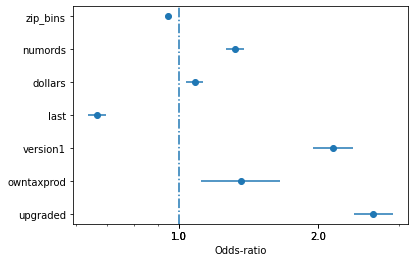

In [103]:
rsm.or_plot(lr_std)

In [104]:
rsm.model_fit(lr_std)


Pseudo R-squared (McFadden): 0.071
Pseudo R-squared (McFadden adjusted): 0.07
Area under the RO Curve (AUC): 17.485
Log-likelihood: -9332.69, AIC: 18681.379, BIC: 18752.328
Chi-squared: 52777.974 df(7), p.value < 0.001 
Nr obs: 52,500



C:\ProgramData\Anaconda3\lib\site-packages\pyrsm\perf.py:678: RuntimeWarning: overflow encountered in long_scalars
  U = np.sum(rankdata(pred)[rvar == False]) - n1 * (n1 + 1) / 2


After running this standardized logistic regression we are able to appreciate that from all the variables selected they all seem to be statistically significant to describe the response variable given that their p-values are found to be really low, except for one exemption - 'owntaxprod' which even thought it has a p-value of 0.002 (which is still significant) does not perform as well as the rest of the variables.

#### Standardize values - Taking out owntaxprod, given the p-value found above

In [105]:
lr_std_df2 = smf.glm(
    formula="res1_yes ~ zip_bins + numords + dollars + last + version1 + upgraded",
    family=Binomial(link=logit()),
    data=intuit75k_std_df1,
).fit()
print(rsm.or_ci(lr_std_df2))

      index     OR     OR%   2.5%  97.5% p.values     
1  zip_bins  0.946   -5.4%  0.940  0.953   < .001  ***
2   numords  1.327   32.7%  1.269  1.389   < .001  ***
3   dollars  1.083    8.3%  1.038  1.129   < .001  ***
4      last  0.666  -33.4%  0.637  0.696   < .001  ***
5  version1  2.132  113.2%  1.927  2.358   < .001  ***
6  upgraded  2.665  166.5%  2.419  2.937   < .001  ***


After taking out 'owntaxprod' variable we now get a model with all values being strongly statistically significant to describe the response variable given that their p-values are found to be really low.

In [106]:
rsm.vif(lr_std_df2)

,variable,vif,Rsq
0,numords,1.544,0.353
1,dollars,1.527,0.345
2,version1,1.076,0.071
3,upgraded,1.076,0.071
4,last,1.017,0.017
5,zip_bins,1.000,0.000


Multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of the regression model. This reduces trust on the p-values identified to be actually statistically significant. This being said, after running the variance influence factor, we can see that the variables selected in this logistic regression seem to be low, demonstrating that there is no concerns of multicollinearity found on the variables included in the model.

Additionally we can explore that the variables with the highest R-squared are 'dollars' and 'numords' which indicates they have the highest influence and representation on the response variables.

In [107]:
odd_ratio_std_df2 = rsm.or_ci(lr_std_df2)
odd_ratio_std_df2

,index,OR,OR%,2.5%,97.5%,p.values,
1,zip_bins,0.946,-5.4%,0.940,0.953,< .001,***
2,numords,1.327,32.7%,1.269,1.389,< .001,***
3,dollars,1.083,8.3%,1.038,1.129,< .001,***
4,last,0.666,-33.4%,0.637,0.696,< .001,***
5,version1,2.132,113.2%,1.927,2.358,< .001,***
6,upgraded,2.665,166.5%,2.419,2.937,< .001,***


#### Odd-Ratio Interpretation

##### The most important variable seem to be 'version1' (2.132), 'upgraded' (2.665) . They seem to be the ones causing the greatest reaction to the response variable.

- 'version1' causing an increase of 113.2% on response variable 'res1-yes'. This means that if a customer has the version 1 is more likely to go ahead with the offer compared to the one's that have version 2.

- 'upgraded' causing an increase of 166.5% on response variable 'res1-yes'. This means that a customer upgraded from version 1 to version 2 is more likely to go ahead with the offer compared to those who did not previously participated in the upgrade.


##### While the least important variables seem to be 'zip_bins' (0.946) and 'dollars' (1.083)

- 'zip_bins' causing an decrease of 5.4% on response variable 'res1-yes'. This means binned zip code variable will not be as relevant to dictate the likelihood of going ahead with the offer

- 'dollars' causing an increase of 8.3% on response variable 'res1-yes'. This means that the total amount ordered from Intuit Direct n the previous months would not be as relevant for the customer to go ahead with the offer.

##### The variables 'numords' (1.389), 'last' (0.637) will have a medium importance

- 'numords' causing an increase of 38.9% on response variable 'res1-yes'. This means that customers with the higher number of orders from Intuit Direct in the previous 36 months are more likely to go ahead with the offer compared to the one's that have version 2.

- 'last' causing an decrease of 33.4% on response variable 'res1-yes'. This means that the more time it has been since the customers last ordered from Intuit Direct the less likely to go ahead with the offer compared to the one's that have version 2.

<AxesSubplot:xlabel='Odds-ratio'>

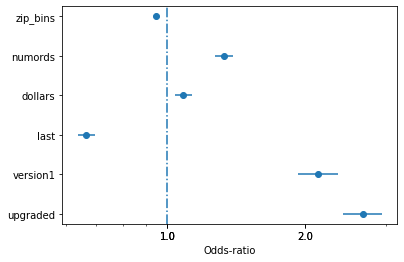

In [108]:
rsm.or_plot(lr_std_df2)

In [109]:
rsm.model_fit(lr_std_df2)


Pseudo R-squared (McFadden): 0.07
Pseudo R-squared (McFadden adjusted): 0.07
Area under the RO Curve (AUC): 17.485
Log-likelihood: -9337.08, AIC: 18688.16, BIC: 18750.24
Chi-squared: 52843.925 df(6), p.value < 0.001 
Nr obs: 52,500



C:\ProgramData\Anaconda3\lib\site-packages\pyrsm\perf.py:678: RuntimeWarning: overflow encountered in long_scalars
  U = np.sum(rankdata(pred)[rvar == False]) - n1 * (n1 + 1) / 2


#### The model interpretation

The R-squared for the model was found to be 0.07 which is small in order to consider this model a good estimator for identifying patterns on the odds of responding yes to the email with the offer to upgrade to the latest version of thee QuickBooks software. This means the model only explains 7.0% of the variation of customer responding 'Yes' to the email.

#### Logistic Regression with Non-Standardize values

In [110]:
lr = smf.glm(
    formula ="res1_yes ~ zip_bins + numords + last + version1 + owntaxprod + upgraded",
    family=Binomial(link=logit()),
    data=intuit75k.query("training == 1"),
).fit()
print(rsm.or_ci(lr))

        index     OR     OR%   2.5%  97.5% p.values     
1    zip_bins  0.946   -5.4%  0.939  0.953   < .001  ***
2     numords  1.300   30.0%  1.262  1.340   < .001  ***
3        last  0.958   -4.2%  0.954  0.963   < .001  ***
4    version1  2.156  115.6%  1.949  2.386   < .001  ***
5  owntaxprod  1.368   36.8%  1.123  1.666    0.002   **
6    upgraded  2.628  162.8%  2.384  2.897   < .001  ***


In [111]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               res1_yes   No. Observations:                52500
Model:                            GLM   Df Residuals:                    52493
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9339.1
Date:                Thu, 10 Feb 2022   Deviance:                       18678.
Time:                        10:53:29   Pearson chi2:                 5.28e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9271      0.069    -42.384      0.000      -3.062      -2.792
zip_bins      -0.0552      0.004    -14.918      0.000      -0.062      -0.048
numords        0.2624      0.015     17.159      0.000       0.232       0.292
last          -0.0427      0.002    -17.997      0.000      -0.047      -0.038
version1       0.7684      0.052     14.882      0.000       0.667       0.870
owntaxprod     0.3131      0.101      3.112      0.002       0.116       0.510
upgraded       0.9662      0.050     19.464      0.000       0.869       1.064
==============================================================================
"""

In [112]:
rsm.vif(lr)

,variable,vif,Rsq
0,upgraded,1.082,0.075
1,version1,1.081,0.075
2,numords,1.032,0.031
3,owntaxprod,1.027,0.026
4,last,1.017,0.017
5,zip_bins,1.000,0.000


In [113]:
odd_ratio_df = rsm.or_ci(lr)
odd_ratio_df

,index,OR,OR%,2.5%,97.5%,p.values,
1,zip_bins,0.946,-5.4%,0.939,0.953,< .001,***
2,numords,1.300,30.0%,1.262,1.340,< .001,***
3,last,0.958,-4.2%,0.954,0.963,< .001,***
4,version1,2.156,115.6%,1.949,2.386,< .001,***
5,owntaxprod,1.368,36.8%,1.123,1.666,0.002,**
6,upgraded,2.628,162.8%,2.384,2.897,< .001,***


<AxesSubplot:xlabel='Odds-ratio'>

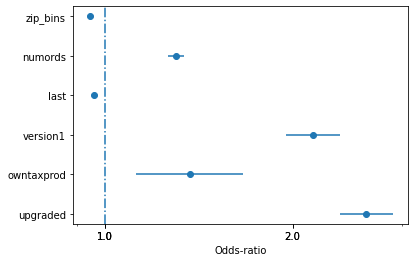

In [114]:
rsm.or_plot(lr)

In [115]:
rsm.model_fit(lr)


Pseudo R-squared (McFadden): 0.07
Pseudo R-squared (McFadden adjusted): 0.07
Area under the RO Curve (AUC): 17.485
Log-likelihood: -9339.093, AIC: 18692.186, BIC: 18754.266
Chi-squared: 52849.948 df(6), p.value < 0.001 
Nr obs: 52,500



C:\ProgramData\Anaconda3\lib\site-packages\pyrsm\perf.py:678: RuntimeWarning: overflow encountered in long_scalars
  U = np.sum(rankdata(pred)[rvar == False]) - n1 * (n1 + 1) / 2


After running this standardized logistic regression we are able to appreciate that from all the variables selected they all seem to be statistically significant to describe the response variable given that their p-values are found to be really low, except for one exemption - 'owntaxprod' which even thought it has a p-value of 0.002 (which is still significant) does not perform as well as the rest of the variables.

#### Non-Standardize logistic regression - Taking out owntaxprod, given the p-value found above

In [116]:
lr_df2 = smf.glm(
    formula="res1_yes ~ zip_bins + numords + dollars + last + version1 + upgraded",
    family=Binomial(link=logit()),
    data=intuit75k.query("training == 1"),
).fit()
print(rsm.or_ci(lr_df2))

      index     OR     OR%   2.5%  97.5% p.values     
1  zip_bins  0.946   -5.4%  0.940  0.953   < .001  ***
2   numords  1.257   25.7%  1.212  1.303   < .001  ***
3   dollars  1.001    0.1%  1.000  1.002   < .001  ***
4      last  0.958   -4.2%  0.954  0.963   < .001  ***
5  version1  2.132  113.2%  1.927  2.358   < .001  ***
6  upgraded  2.665  166.5%  2.419  2.937   < .001  ***


After taking out 'owntaxprod' variable we now get a model with all values being strongly statistically significant to describe the response variable given that their p-values are found to be really low.

In [117]:
rsm.vif(lr_df2)

,variable,vif,Rsq
0,numords,1.544,0.353
1,dollars,1.527,0.345
2,version1,1.076,0.071
3,upgraded,1.076,0.071
4,last,1.017,0.017
5,zip_bins,1.000,0.000


Multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of the regression model. This reduces trust on the p-values identified to be actually statistically significant. This being said, after running the variance influence factor, we can see that the variables selected in this logistic regression seem to be low, demonstrating that there is no concerns of multicollinearity found on the variables included in the model.

Additionally we can explore that the variables with the highest R-squared are 'dollars' and 'numords' which indicates they have the highest influence and representation on the response variables.

In [118]:
odd_ratio_df2 = rsm.or_ci(lr_df2)
odd_ratio_df2

,index,OR,OR%,2.5%,97.5%,p.values,
1,zip_bins,0.946,-5.4%,0.940,0.953,< .001,***
2,numords,1.257,25.7%,1.212,1.303,< .001,***
3,dollars,1.001,0.1%,1.000,1.002,< .001,***
4,last,0.958,-4.2%,0.954,0.963,< .001,***
5,version1,2.132,113.2%,1.927,2.358,< .001,***
6,upgraded,2.665,166.5%,2.419,2.937,< .001,***


#### Odd-Ratio Interpretation

##### The most important variable seem to be 'version1' (2.132), 'upgraded' (2.665) . They seem to be the ones causing the greatest reaction to the response variable.

- 'version1' causing an increase of 113.2% on response variable 'res1-yes'. This means that if a customer has the version 1 is more likely to go ahead with the offer compared to the one's that have version 2.

- 'upgraded' causing an increase of 166.5% on response variable 'res1-yes'. This means that a customer upgraded from version 1 to version 2 is more likely to go ahead with the offer compared to those who did not previously participated in the upgrade.


##### While the least important variables seem to be 'zip_bins' (0.946), 'last' (0.954) and 'dollars' (1.001)

- 'zip_bins' causing an decrease of 5.4% on response variable 'res1-yes'. This means binned zip code variable will not be as relevant to dictate the likelihood of going ahead with the offer

- 'dollars' causing an increase of 8.3% on response variable 'res1-yes'. This means that the total amount ordered from Intuit Direct n the previous months would not be as relevant for the customer to go ahead with the offer.

- 'last' causing an decrease of 4.2% on response variable 'res1-yes'. This means that the more time it has been since the customers last ordered from Intuit Direct the less likely to go ahead with the offer compared to the one's that have version 2.

##### The variables 'numords' (1.212) will have a medium importance

- 'numords' causing an increase of 25.7% on response variable 'res1-yes'. This means that customers with the higher number of orders from Intuit Direct in the previous 36 months are more likely to go ahead with the offer compared to the one's that have version 2.

<AxesSubplot:xlabel='Odds-ratio'>

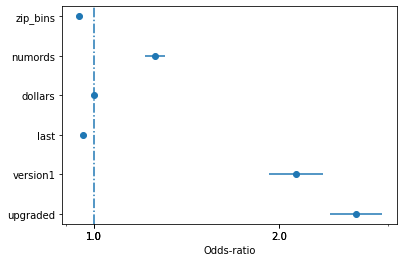

In [119]:
rsm.or_plot(lr_df2)

In [120]:
rsm.model_fit(lr_df2)


Pseudo R-squared (McFadden): 0.07
Pseudo R-squared (McFadden adjusted): 0.07
Area under the RO Curve (AUC): 17.485
Log-likelihood: -9337.08, AIC: 18688.16, BIC: 18750.24
Chi-squared: 52843.925 df(6), p.value < 0.001 
Nr obs: 52,500



C:\ProgramData\Anaconda3\lib\site-packages\pyrsm\perf.py:678: RuntimeWarning: overflow encountered in long_scalars
  U = np.sum(rankdata(pred)[rvar == False]) - n1 * (n1 + 1) / 2


#### The model interpretation

The R-squared for the model was found to be 0.07 which is small in order to consider this model a good estimator for identifying patterns on the odds of responding yes to the email with the offer to upgrade to the latest version of thee QuickBooks software. This means the model only explains 7.0% of the variation of customer responding 'Yes' to the email.

#### Model selected as the predictor in order to assign groups

In [1]:
rsm.predict_ci(lr_df2, intuit75k)

NameError: name 'rsm' is not defined

#### Assignning a variable pred logit according to what is found on the logistic regression and the different variables that each row has

In [122]:
intuit75k["pred_logit"] = rsm.predict_ci(lr, intuit75k).prediction

#### Assignning a deciles according to pred logit in order to divide them into 10 groups

In [123]:
intuit75k_df2 = intuit75k#[intuit75k['training'] == 0]

intuit75k_df2['deciles'] = lr.predict(intuit75k_df2.query("training == 0"))
intuit75k_df2['deciles']

intuit75k_df2["dec_logit"] = rsm.xtile(intuit75k_df2['deciles'], 10, rev = True)

In [124]:
intuit75k_df2.groupby("dec_logit")["res1_yes"].agg(["count", "sum"]).reset_index().rename(columns = {"count" : "Number of Emails",
                                                                                        "sum" : "Responded Yes"})

,dec_logit,Number of Emails,Responded Yes
0,1.0,2247,336
1,2.0,2253,157
2,3.0,2250,151
3,4.0,2250,113
4,5.0,2249,100
5,6.0,2248,66
6,7.0,2248,57
7,8.0,2250,55
8,9.0,2253,39
9,10.0,2252,29


In [125]:
df_dec_logit = intuit75k_df2.groupby("dec_logit")["res1_yes"].agg(["count", "sum"]).reset_index().rename(columns = {"count" : "Number of Emails",
                                                                                        "sum" : "Responded Yes"})

df_dec_logit["Requested Upgrade Rate"] = df_dec_logit["Responded Yes"]/df_dec_logit["Number of Emails"]

df_dec_logit

,dec_logit,Number of Emails,Responded Yes,Requested Upgrade Rate
0,1.0,2247,336,0.149533
1,2.0,2253,157,0.069685
2,3.0,2250,151,0.067111
3,4.0,2250,113,0.050222
4,5.0,2249,100,0.044464
5,6.0,2248,66,0.029359
6,7.0,2248,57,0.025356
7,8.0,2250,55,0.024444
8,9.0,2253,39,0.017310
9,10.0,2252,29,0.012877


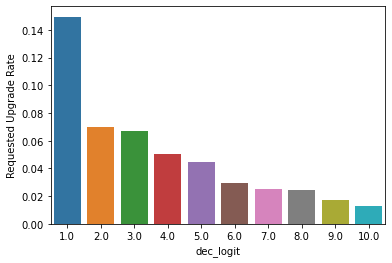

In [126]:
fig = sns.barplot(data = df_dec_logit, x = "dec_logit", y = "Requested Upgrade Rate")

#### Lift, Gains, and Profit

In [127]:
df_dec_logit["Cum Number of Emails"] = df_dec_logit["Number of Emails"].cumsum()#/df_dec_logit["Number of Impressions"].sum()
df_dec_logit["Cum Responded Yes"] = df_dec_logit["Responded Yes"].cumsum()
df_dec_logit["Cum Prop of Number of Emails"] = (df_dec_logit["Cum Number of Emails"]/df_dec_logit["Cum Number of Emails"].sum()).cumsum()

aaa = df_dec_logit["Responded Yes"].sum()/df_dec_logit["Number of Emails"].sum()
aaa
df_dec_logit["Cum Requested Upgrade Rate"] = df_dec_logit["Cum Responded Yes"]/df_dec_logit["Cum Number of Emails"]


df_dec_logit["Lift"] = df_dec_logit["Requested Upgrade Rate"]/aaa
df_dec_logit["Cum Lift"] = df_dec_logit["Cum Requested Upgrade Rate"]/aaa


df_dec_logit.head()

,dec_logit,Number of Emails,Responded Yes,Requested Upgrade Rate,Cum Number of Emails,Cum Responded Yes,Cum Prop of Number of Emails,Cum Requested Upgrade Rate,Lift,Cum Lift
0,1.0,2247,336,0.149533,2247,336,0.018160,0.149533,3.050305,3.050305
1,2.0,2253,157,0.069685,4500,493,0.054530,0.109556,1.421495,2.234814
2,3.0,2250,151,0.067111,6750,644,0.109083,0.095407,1.368994,1.946207
3,4.0,2250,113,0.050222,9000,757,0.181822,0.084111,1.024479,1.715775
4,5.0,2249,100,0.044464,11249,857,0.272737,0.076185,0.907021,1.554082


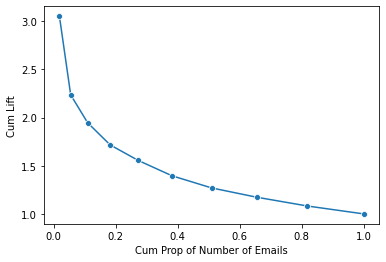

In [128]:
fig2 = sns.lineplot(data = df_dec_logit, x = "Cum Prop of Number of Emails", y = "Cum Lift" , marker = 'o')

In [129]:
df_dec_logit["Gains"] = df_dec_logit["Responded Yes"]/df_dec_logit["Responded Yes"].sum()
df_dec_logit["Cum Gains"] = df_dec_logit["Gains"].cumsum()

df_dec_logit

,dec_logit,Number of Emails,Responded Yes,Requested Upgrade Rate,Cum Number of Emails,Cum Responded Yes,Cum Prop of Number of Emails,Cum Requested Upgrade Rate,Lift,Cum Lift,Gains,Cum Gains
0,1.0,2247,336,0.149533,2247,336,0.018160,0.149533,3.050305,3.050305,0.304624,0.304624
1,2.0,2253,157,0.069685,4500,493,0.054530,0.109556,1.421495,2.234814,0.142339,0.446963
2,3.0,2250,151,0.067111,6750,644,0.109083,0.095407,1.368994,1.946207,0.136899,0.583862
3,4.0,2250,113,0.050222,9000,757,0.181822,0.084111,1.024479,1.715775,0.102448,0.686310
4,5.0,2249,100,0.044464,11249,857,0.272737,0.076185,0.907021,1.554082,0.090662,0.776972
5,6.0,2248,66,0.029359,13497,923,0.381820,0.068386,0.598900,1.394991,0.059837,0.836809
6,7.0,2248,57,0.025356,15745,980,0.509072,0.062242,0.517232,1.269669,0.051677,0.888486
7,8.0,2250,55,0.024444,17995,1035,0.654509,0.057516,0.498640,1.173263,0.049864,0.938350
8,9.0,2253,39,0.017310,20248,1074,0.818154,0.053042,0.353110,1.082005,0.035358,0.973708
9,10.0,2252,29,0.012877,22500,1103,1.000000,0.049022,0.262686,1.000000,0.026292,1.000000


In [130]:
gains_tab = df_dec_logit
gains_tab

new_row = pd.DataFrame({'dec_logit':0, 'Number of Emails':0, 'Responded Yes':0,
       'Requested Upgrade Rate':0, 'Cum Number of Emails':0, 'Cum Responded Yes':0,
       'Cum Prop of Number of Emails':0, 'Cum Requested Upgrade Rate':0, 'Lift':0, 'Cum Lift':0,
       'Gains':0, 'Cum Gains':0}, index=[0])

gains_tab = pd.concat([new_row, gains_tab]).reset_index(drop = True)
gains_tab

,dec_logit,Number of Emails,Responded Yes,Requested Upgrade Rate,Cum Number of Emails,Cum Responded Yes,Cum Prop of Number of Emails,Cum Requested Upgrade Rate,Lift,Cum Lift,Gains,Cum Gains
0,0.0,0,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,2247,336,0.149533,2247,336,0.018160,0.149533,3.050305,3.050305,0.304624,0.304624
2,2.0,2253,157,0.069685,4500,493,0.054530,0.109556,1.421495,2.234814,0.142339,0.446963
3,3.0,2250,151,0.067111,6750,644,0.109083,0.095407,1.368994,1.946207,0.136899,0.583862
4,4.0,2250,113,0.050222,9000,757,0.181822,0.084111,1.024479,1.715775,0.102448,0.686310
5,5.0,2249,100,0.044464,11249,857,0.272737,0.076185,0.907021,1.554082,0.090662,0.776972
6,6.0,2248,66,0.029359,13497,923,0.381820,0.068386,0.598900,1.394991,0.059837,0.836809
7,7.0,2248,57,0.025356,15745,980,0.509072,0.062242,0.517232,1.269669,0.051677,0.888486
8,8.0,2250,55,0.024444,17995,1035,0.654509,0.057516,0.498640,1.173263,0.049864,0.938350
9,9.0,2253,39,0.017310,20248,1074,0.818154,0.053042,0.353110,1.082005,0.035358,0.973708


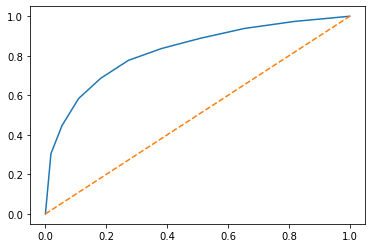

In [131]:
plt.plot(gains_tab["Cum Prop of Number of Emails"], gains_tab["Cum Gains"], label = 'line 1', linestyle = 'solid')
plt.plot([0,1], [0,1], label = 'line 2', linestyle = 'dashed')

In [132]:
cost = 1.41 # each mail piece costs $1.41
margin = 60 # the margin (or net revenue) from each responder, excluding the mailing cost, is $60
breakeven =  cost/margin # float, length 1

In [133]:
profit_tab = df_dec_logit[['dec_logit', 'Number of Emails', 'Responded Yes', 'Cum Prop of Number of Emails']]
profit_tab['Cost'] = profit_tab['Number of Emails']*cost
profit_tab['Revenue'] = profit_tab['Responded Yes']*margin
profit_tab['Profit'] = profit_tab['Revenue'] - profit_tab['Cost']


profit_tab

C:\Users\Rohan\AppData\Local\Temp/ipykernel_105448/705169543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_tab['Cost'] = profit_tab['Number of Emails']*cost
C:\Users\Rohan\AppData\Local\Temp/ipykernel_105448/705169543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_tab['Revenue'] = profit_tab['Responded Yes']*margin
C:\Users\Rohan\AppData\Local\Temp/ipykernel_105448/705169543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,dec_logit,Number of Emails,Responded Yes,Cum Prop of Number of Emails,Cost,Revenue,Profit
0,1.0,2247,336,0.018160,3168.27,20160,16991.73
1,2.0,2253,157,0.054530,3176.73,9420,6243.27
2,3.0,2250,151,0.109083,3172.50,9060,5887.50
3,4.0,2250,113,0.181822,3172.50,6780,3607.50
4,5.0,2249,100,0.272737,3171.09,6000,2828.91
5,6.0,2248,66,0.381820,3169.68,3960,790.32
6,7.0,2248,57,0.509072,3169.68,3420,250.32
7,8.0,2250,55,0.654509,3172.50,3300,127.50
8,9.0,2253,39,0.818154,3176.73,2340,-836.73
9,10.0,2252,29,1.000000,3175.32,1740,-1435.32


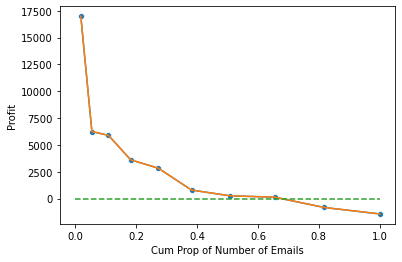

In [134]:
fig4 = sns.lineplot(data = profit_tab, x = "Cum Prop of Number of Emails", y = "Profit" , marker = 'o')

plt.plot(profit_tab["Cum Prop of Number of Emails"], profit_tab["Profit"], label = 'line 1', linestyle = 'solid')
plt.plot([0,1], [0,0], label = 'line 2', linestyle = 'dashed')

In [135]:
intuit75k_test = intuit75k[intuit75k['training'] == 0]
target_logit_df = intuit75k_df3["pred_logit"] > breakeven

In [136]:
intuit75k_df4 = intuit75k_df3.groupby(intuit75k["pred_logit"] > breakeven)
vvv2 = intuit75k_df4['res1_yes'].value_counts()
vvv2

pred_logit  res1_yes
False       0            6406
            1             116
True        0           14991
            1             987
Name: res1_yes, dtype: int64

In [ ]:
intuit75k_df3


tuango["smsto_sq"] = tuango.rfm_sq_resp > breakeven

In [137]:
TP = vvv2[1][1]
FP = vvv2[1][0]
TN = vvv2[0][0]
FN = vvv2[0][1]

In [138]:
# confusion matrix 0.22% and 0.10% 
cm_logit = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN] # TP, FP, TN, and FN values in that order
    }
)
cm_logit

,label,nr
0,TP,987
1,FP,14991
2,TN,6406
3,FN,116


In [139]:
accuracy_logit = (TP + TN)/cm_logit['nr'].sum()# float
accuracy_logit

0.3285777777777778

#### Confusion matrices

After running the confusion matrix it is clear that the logit model has a high level of differentiation, knows how to target correctly and assign prediction based on this test. This model has a high prediction of True Positive (TP) values with 987, which means it detects quite sharp unfortunately it has a high production of False Positive (FP) values with 14991 which would end up rising the cost of resources (sending emails) of doing the marketting campaign.

In [140]:

profit = (TP * margin) - (TP + FP) * 1.41
profit

36691.020000000004

#### Model Performance

In [141]:
intuit75k["target_logit"] = rsm.ifelse(intuit75k.pred_logit * 0.5 > breakeven, True, False)
intuit75k["target_logit"].value_counts()

False    47421
True     27579
Name: target_logit, dtype: int64

In [142]:
test_df1 = intuit75k[intuit75k["target_logit"] == True]
test_df1.res1_yes.value_counts()

0    25212
1     2367
Name: res1_yes, dtype: int64

In [143]:
intuit75k[intuit75k['training']==0].head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq,pred_logit,deciles,dec_logit,target_logit
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,5,3,153,5,2,152,0.032690,0.032690,6.0,False
2,3,37091,8,Male,0,4,93.0,14,29,0,...,1,2,312,1,5,315,0.124466,0.124466,1.0,True
4,5,60201,11,Male,0,1,24.5,2,3,0,...,5,5,155,5,4,154,0.033659,0.033659,6.0,False
6,7,22980,5,Male,0,1,49.5,13,36,1,...,5,4,254,5,2,252,0.061372,0.061372,3.0,True
8,9,34950,8,Male,0,1,44.5,15,4,0,...,5,4,354,5,3,353,0.023049,0.023049,8.0,False


In [205]:
nr_emails_logit = len(test_df1)
perc_emails_logit = len(test_df1)/len(intuit75k_df3)

response_rate_logit = test_df1.res1_yes.value_counts(normalize = True)[1]
nr_responses_logit = response_rate_logit*nr_emails_logit

cost_email = len(test_df1)*cost
revenue_logit = test_df1.res1_yes.value_counts()[1]*margin
profit_logit = revenue_logit - cost_email

ROME_logit = profit_logit/cost_email

profit

35059.2

In [206]:
print(
    f"""Targetting Quickbooks with logit would email all {int(nr_emails_logit):,} ({round((100 * perc_emails_logit), 2)}%) customers. The response rate for the selected customers is predicted to be {round((100 * response_rate_logit), 2)}% or {int(nr_responses_logit):,}
buyers. The revenue is equal to ${int(revenue_logit):,}. The expected profit is ${int(profit):,}. The email cost is estimated to be ${int(cost_email):,} with a ROME of {round((100 * ROME_logit), 2)}%"""
)

Targetting Quickbooks with logit would email all 27,579 (122.57%) customers. The response rate for the selected customers is predicted to be 8.58% or 2,367
buyers. The revenue is equal to $142,020. The expected profit is $35,059. The email cost is estimated to be $38,886 with a ROME of 265.22%


In [150]:
scale1 = round((100 * perc_emails_logit), 2)
scale2 = round((100 * response_rate_logit), 2)
tot_emails = 801821 - 38487
total_cost = scale1*tot_emails*cost
total_revenue = tot_emails*round((100 * response_rate_logit), 2)*margin
total_revenue

392964343.2

No handles with labels found to put in legend.


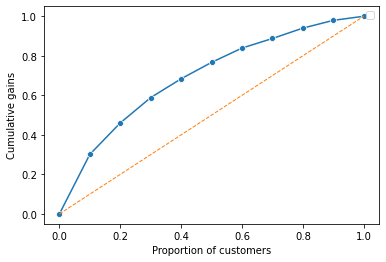

In [177]:
fig = rsm.gains_plot(intuit75k[intuit75k.training == 1], "res1_yes", 1, "pred_logit").legend(title=None)

In [152]:
tpr = TP/(TP+FN)
specificity = TN/(TN+FP)
fpr = 1- specificity

In [156]:
y = intuit75k.res1_yes
y_prob = rsm.ifelse(intuit75k["pred_logit"] * 0.5 > breakeven, 1 ,0)

In [157]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y, y_prob)

In [158]:
auc = metrics.roc_auc_score(y, y_prob)

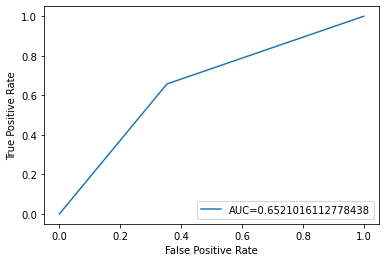

In [159]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [170]:
len(intuit75k[intuit75k['training']==0])

22500

In [176]:
intuit75k_csv = intuit75k[intuit75k['training']==0]

intuit75k_csv["target"] = rsm.ifelse(intuit75k_csv["pred_logit"] * 0.5 > breakeven, True ,False)


C:\Users\Rohan\AppData\Local\Temp/ipykernel_105448/3167277150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intuit75k_csv["target"] = rsm.ifelse(intuit75k_csv["pred_logit"] * 0.5 > breakeven, True ,False)


In [178]:
intuit75k_csv[['id', 'target']].to_csv('Arnva_Akanksha_Renato_Rohan_Group24.csv')

 After running analysis on the data, we find the response rate, expected revenue and profit for the three scenarios: 

- Targetting Quickbooks with logit would email all 15,978 (71.01%) customers. The response rate for the selected customers is predicted to be 6.18% or 987
buyers. The revenue is equal to 59,220. The expected profit is 36,691. The email cost is estimated to be 22,528 with a ROME of 162.86%

We can observe that with the Logistic Regression approach we are able to narrow down our targetted number of customers, reducing the amount of emails to be sent and therefore allowing us to increase the expected profit compared to the RFM model. Which when scalable to do a bigger marketing campaign, like the projected 763,334 customers to be targetted in the second-wave, we would get more profit.

### Neural Networks

Our RFM and Logistic models have given us some promosing results. In order to better evaluate our mailing prediction, we will use neural networks and build a model accordingly to come up with potential profit. 

Neural Networks usually consist of two major hyperparameters that controls its architecture : The number of layers and the numbers of nodes in each hidden layers.

In [179]:
def nn(X, y, hlsizes=(1,), max_iter=1000):
    return MLPClassifier(
        activation="tanh",
        solver="lbfgs",
        hidden_layer_sizes=hlsizes,
        random_state=1234,
        max_iter=max_iter,
    ).fit(X, y)


def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

In [180]:
X = intuit75k.copy()

In order to make our modelling feasible, we factorised two of our significant variables "sex"  and "res1".

In [181]:
X['sex'],_ = X['sex'].factorize()
X['res1'],_ = X['res1'].factorize()

The 'X_NEW' dataframe contains all the information relevant to the significant variables mentioned below. These response variables were also used in making our logistic model and gave us the optimal result.

In [182]:
X_NEW = X[['zip_bins','numords', 'last', 'version1', 'owntaxprod' , 'upgraded']].copy()
y = intuit75k.res1_yes

After thorough analysis, we came up with the appropriate number of nodes and hidden layers. The right combination which we decided to work on was 7 nodes and 9 hidden layers. These hyperparameters gave us the appropriate amount of profit. Adding more modes and hidden layers adds felxibilty to our model. This helped us in fitting the training data.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


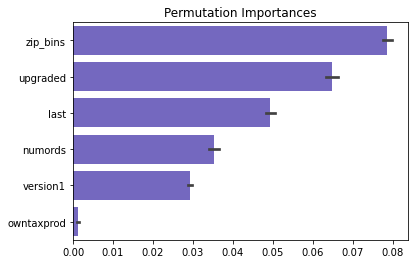

In [186]:
clf = nn(X_NEW[intuit75k.training == 1], y[intuit75k.training == 1], (6,3))
intuit75k["pred_nn1"] = clf.predict_proba(X_NEW)[:, 1]  # predicting for the full dataset
fig = importance(clf, X_NEW[intuit75k.training == 1], y[intuit75k.training == 1], X_NEW.columns)

As we can observe in the above figure, the permutation importances for all the explanatory variables are given in the descending order. 'zip_bins' have the highest importance.

In [190]:
test_df2 = intuit75k[intuit75k['training'] == 0]
test_df3 = test_df2.groupby(intuit75k["pred_nn1"] * 0.5 > breakeven)
vvv2 = test_df3['res1_yes'].value_counts()
test_df3['res1_yes'].value_counts()

pred_nn1  res1_yes
False     0           15263
          1             357
True      0            6134
          1             746
Name: res1_yes, dtype: int64

The above code was executed in order to find TP, FP, TN, FN. These variables will further be used to create a confusion matrix for the calculation of profit.

In [191]:
TP = vvv2[1][1]
FP = vvv2[1][0]
TN = vvv2[0][0]
FN = vvv2[0][1]

In [192]:
# confusion matrix
cm_logit_recalc = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN]# TP, FP, TN, and FN values in that order
    }
)

cm_logit_recalc

,label,nr
0,TP,746
1,FP,6134
2,TN,15263
3,FN,357


In [193]:
accuracy_logit_recalc = (TP + TN)/cm_logit_recalc['nr'].sum()# float
accuracy_logit_recalc

0.7115111111111111

The accuracy for our neural network model was calculated and it came out to be approximately 72.4%. Accuracy is truely not the right metric to measure the effectiveness of our model. This is because, in terms of business, we want to focus on metrics like profit which is usually computed using True Positives: Users whom the model predicted to send the mail and they were send. But at the same time, as we can observe, our False Positives are also very high which means that our model predicted to send mail to those users who were not supposed to be mails. This would likely result in incurring high amount of cost without any revenue from this cohort.

In [194]:
profit = (TP * margin) - (TP + FP) * 1.41
profit

35059.2

The profit for our neural netwrok model comes out to be 35059.2 USD.

In [195]:
tpr = TP/(TP+FN)
specificity = TN/(TN+FP)
fpr = 1- specificity

In [196]:
tpr, fpr

(0.6763372620126926, 0.28667570220124317)

In [197]:
y_prob = rsm.ifelse(intuit75k["pred_nn1"] * 0.5 > breakeven, 1 ,0)

In [198]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y, y_prob)

In [199]:
auc = metrics.roc_auc_score(y, y_prob)

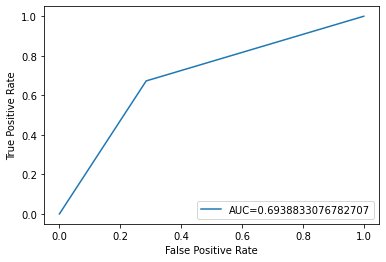

In [200]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

No handles with labels found to put in legend.


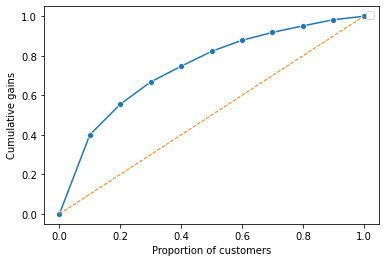

In [201]:
fig = rsm.gains_plot(intuit75k[intuit75k.training == 1], "res1_yes", 1, "pred_nn1").legend(title=None)

In [ ]:
#END 